# **Semantix**
## Desafio Data Science

### Questões
#### 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?
#### 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais
#### são os pontos relevantes a serem observados?
#### 3. Baseando-se nos resultados de adesão desta campanha qual o número médio e
#### o máximo de ligações que você indica para otimizar a adesão?
#### 4. O resultado da campanha anterior tem relevância na campanha atual?
#### 5. Qual o fator determinante para que o banco exija um seguro de crédito?
#### 6. Quais são as características mais proeminentes de um cliente que possua
#### empréstimo imobiliário?

#### importando bibliotecas do python, de uso comum em data science.

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
# Imports
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [3]:
## Lendo os dados do arquivo csv e transformando em pandas dataframe
df = pd.read_csv('bank-full.csv', sep= ";")
df = pd.DataFrame(df)
des = df.describe()
des.head()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000


In [5]:
## Verificando se alguma coluna tem valores nulos
col = df.columns
for item in col:
    print(item + ' ' + 'Null Values: ', df[item].isnull().any())

age Null Values:  False
job Null Values:  False
marital Null Values:  False
education Null Values:  False
default Null Values:  False
balance Null Values:  False
housing Null Values:  False
loan Null Values:  False
contact Null Values:  False
day Null Values:  False
month Null Values:  False
duration Null Values:  False
campaign Null Values:  False
pdays Null Values:  False
previous Null Values:  False
poutcome Null Values:  False
y Null Values:  False


#### Conclusão: Não há feature com valores nulos.

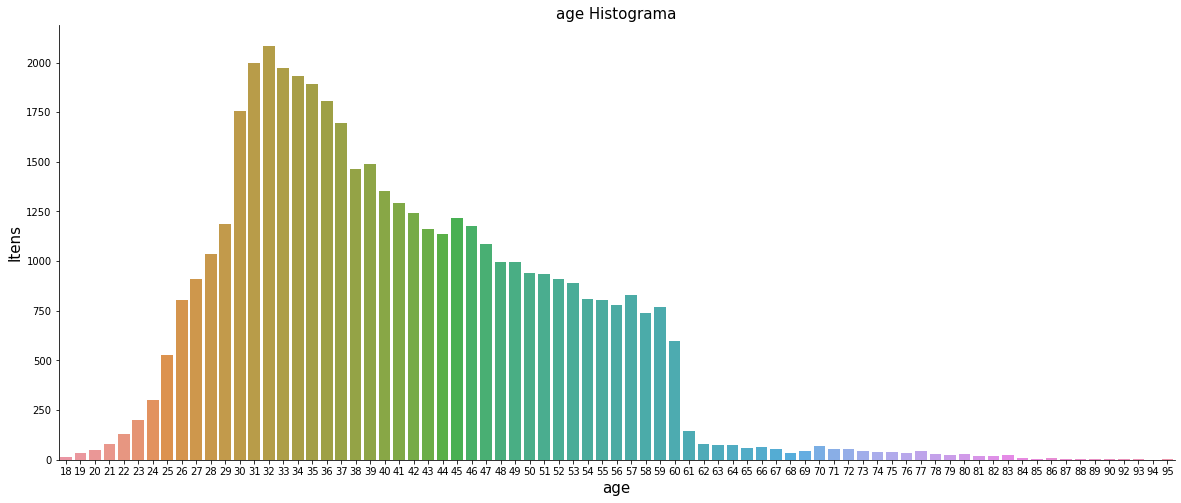

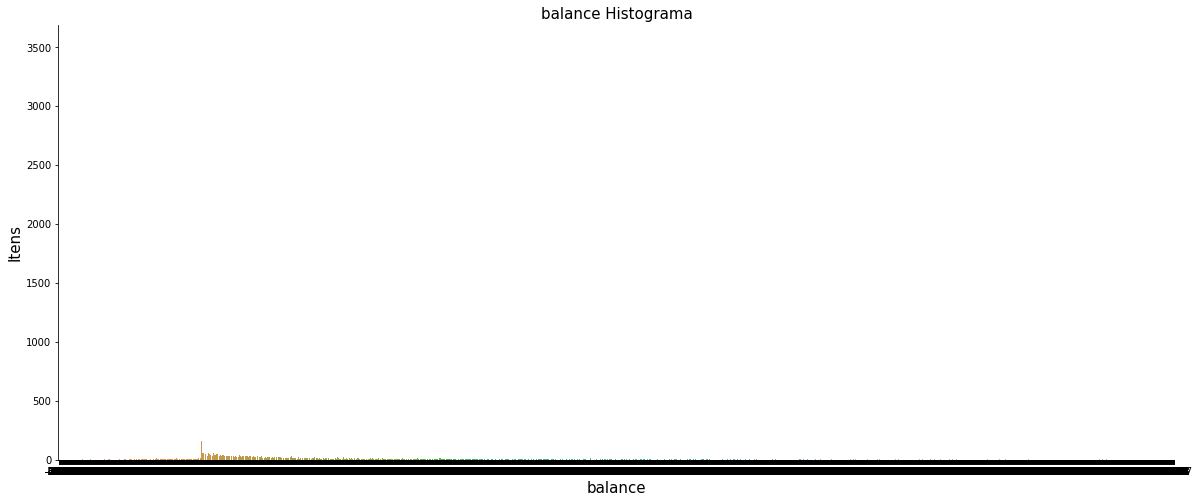

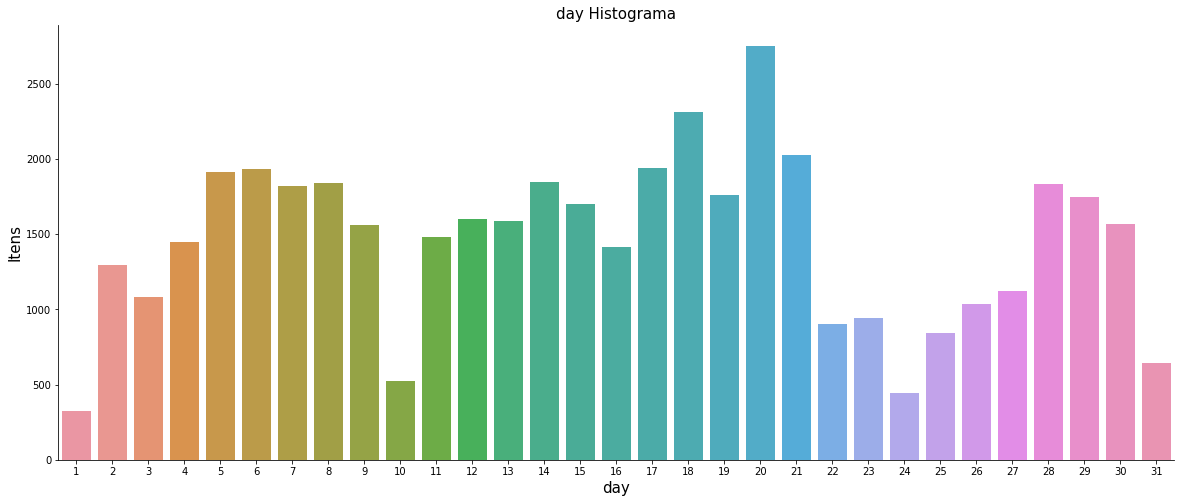

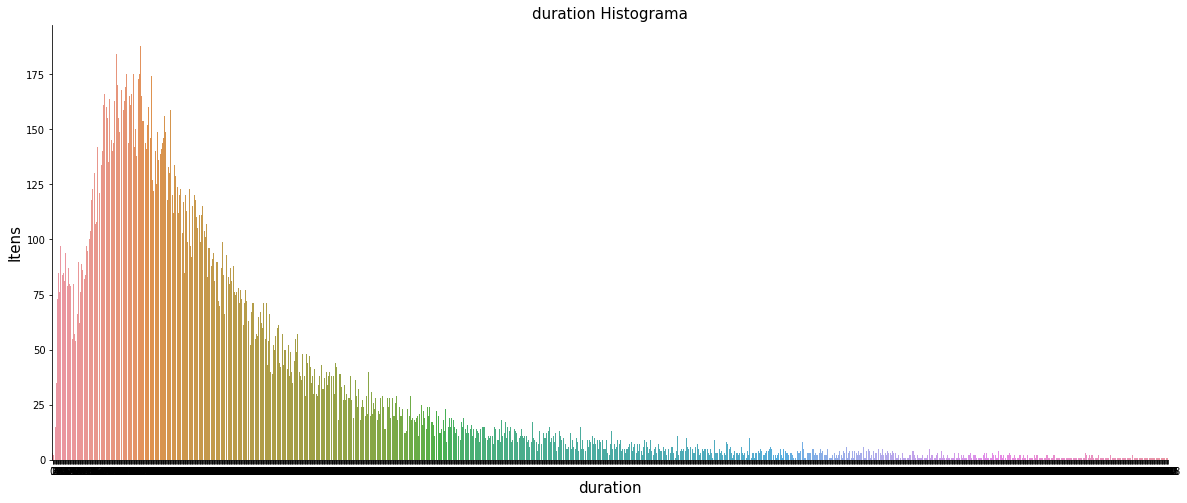

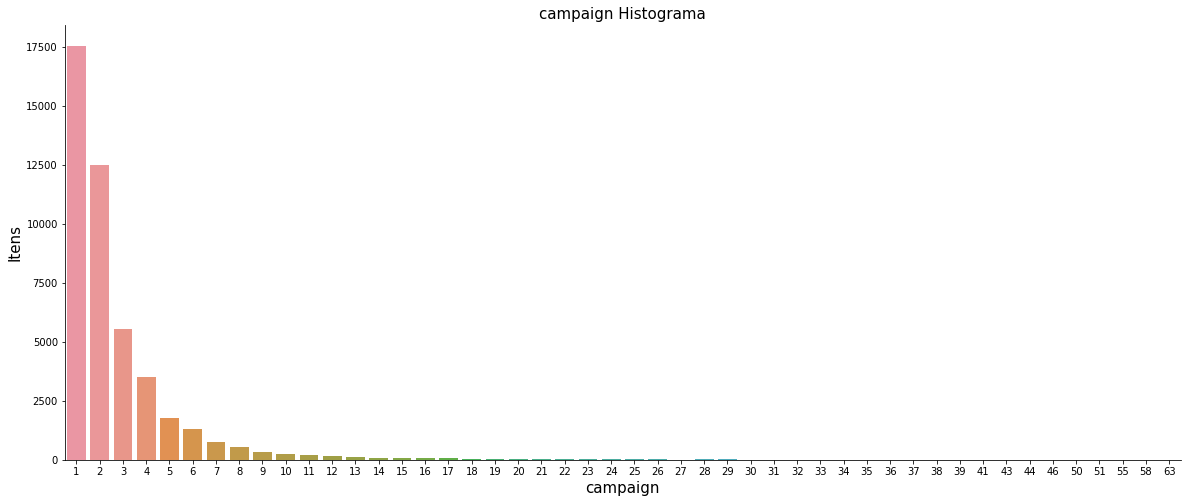

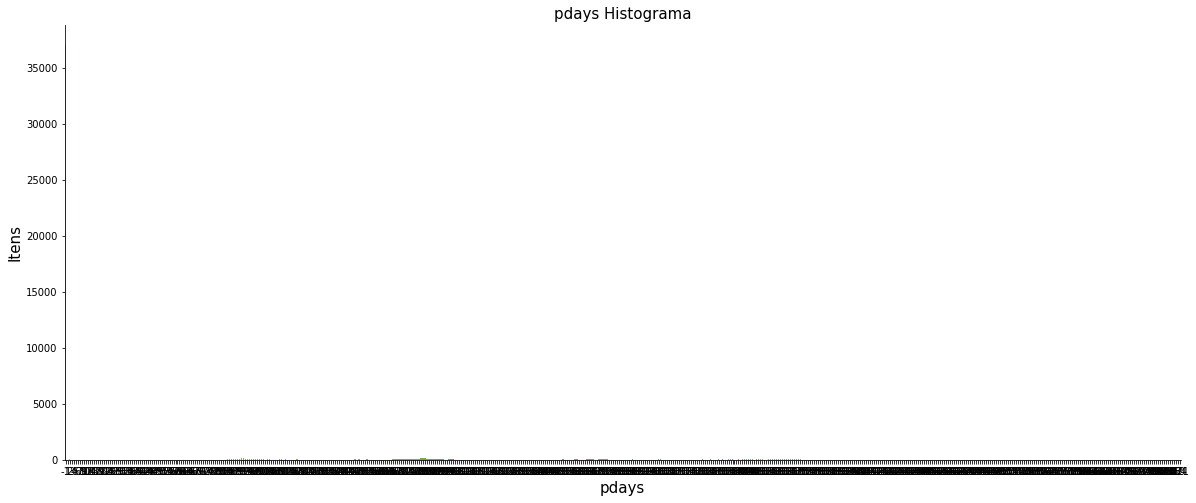

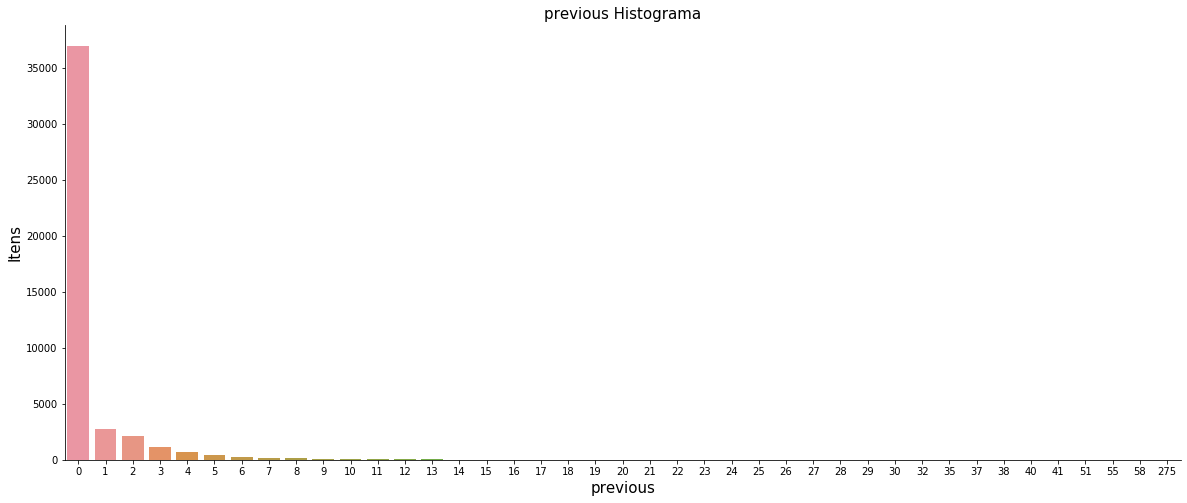

In [6]:
## Criando histogramas de cada variável numérica para conhecer a distribuição de cada uma
for c in des.columns:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 8)
    sb.countplot(x = c, data = df)
    ax.set_xlabel(c, fontsize=15)
    ax.set_ylabel('Itens', fontsize=15)
    ax.set_title(c + ' Histograma', fontsize=15)
    sb.despine()

In [7]:
## Identificando estatisticamente possíveis outliers
for otlrs in des.columns:
    print('Calculo de outliers de ' + otlrs)
    print('1º Quartil: ', df[otlrs].quantile(q = 0.25))
    print('2º Quartil: ', df[otlrs].quantile(q = 0.50))
    print('3º Quartil: ', df[otlrs].quantile(q = 0.75))
    print('4º Quartil: ', df[otlrs].quantile(q = 1.00))
    print(otlrs + ' acima de: ', df[otlrs].quantile(q = 0.75) + 
                      1.5*(df[otlrs].quantile(q = 0.75) - df[otlrs].quantile(q = 0.25)), 'são outliers')
    print()
    print('Numero de outliers: ', df[df[otlrs] > 69.6][otlrs].count())
    print('Numero de clientes: ', len(df))
    print('Outliers são:', round(df[df[otlrs] > 69.6][otlrs].count()*100/len(df),2), '%')
    print()
    print()

Calculo de outliers de age
1º Quartil:  33.0
2º Quartil:  39.0
3º Quartil:  48.0
4º Quartil:  95.0
age acima de:  70.5 são outliers

Numero de outliers:  554
Numero de clientes:  45211
Outliers são: 1.23 %


Calculo de outliers de balance
1º Quartil:  72.0
2º Quartil:  448.0
3º Quartil:  1428.0
4º Quartil:  102127.0
balance acima de:  3462.0 são outliers

Numero de outliers:  34018
Numero de clientes:  45211
Outliers são: 75.24 %


Calculo de outliers de day
1º Quartil:  8.0
2º Quartil:  16.0
3º Quartil:  21.0
4º Quartil:  31.0
day acima de:  40.5 são outliers

Numero de outliers:  0
Numero de clientes:  45211
Outliers são: 0.0 %


Calculo de outliers de duration
1º Quartil:  103.0
2º Quartil:  180.0
3º Quartil:  319.0
4º Quartil:  4918.0
duration acima de:  643.0 são outliers

Numero de outliers:  39235
Numero de clientes:  45211
Outliers são: 86.78 %


Calculo de outliers de campaign
1º Quartil:  1.0
2º Quartil:  2.0
3º Quartil:  3.0
4º Quartil:  63.0
campaign acima de:  6.0 são outl

In [8]:
## Analisando o coeficiente de variação das variáveis numéricas
for vr in des.columns:
    print('Variação de: ' + vr)
    print('Média:', round(df[vr].mean(), 1))
    print('Desvio padrão :', round(df[vr].std(), 1))
    print('Coeficiente de Variação  :', round(df[vr].std()*100/df[vr].mean(), 1), end='%.')
    if round(df[vr].std()*100/df[vr].mean(), 1) < 15:
        print(' Baixa variação')
    elif ((round(df[vr].std()*100/df[vr].mean(), 1) >= 15) and (round(df[vr].std()*100/df[vr].mean(), 1)) <= 30):
        print(' Média variação')
    else:
        print(' Alta variação')
    print()

Variação de: age
Média: 40.9
Desvio padrão : 10.6
Coeficiente de Variação  : 25.9%. Média variação

Variação de: balance
Média: 1362.3
Desvio padrão : 3044.8
Coeficiente de Variação  : 223.5%. Alta variação

Variação de: day
Média: 15.8
Desvio padrão : 8.3
Coeficiente de Variação  : 52.7%. Alta variação

Variação de: duration
Média: 258.2
Desvio padrão : 257.5
Coeficiente de Variação  : 99.8%. Alta variação

Variação de: campaign
Média: 2.8
Desvio padrão : 3.1
Coeficiente de Variação  : 112.1%. Alta variação

Variação de: pdays
Média: 40.2
Desvio padrão : 100.1
Coeficiente de Variação  : 249.1%. Alta variação

Variação de: previous
Média: 0.6
Desvio padrão : 2.3
Coeficiente de Variação  : 396.9%. Alta variação



### Início das respostas às questões.

### 1. Qual profissão tem mais tendência a fazer um empréstimo? De qual tipo?
#### Para esta questão, utilizaremos visualização de um histograma para ver qual profissão tem maior quantidade de 
#### empréstimo e de qual tipo.

In [9]:
## Inicialmente, vamos estudar, qual a % de clientes possui apenas um tipo de empréstimo e qual e também qual a % que 
## possui os dois empréstimos.

df = pd.DataFrame(df)

both = 0
housing = 0
loan = 0
noloan = 0

for i in range(0, len(df)):
    if (df.iloc[i].housing == 'yes'):
        if (df.iloc[i].loan == 'yes'):
            both = both + 1
        else:
            housing = housing + 1
    elif (df.iloc[i].loan == 'no'):
        noloan = noloan + 1
    else:
        loan = loan + 1

bothp = round(both / len(df) * 100, 1)
housingp = round(housing / len(df) * 100, 1)
loanp = round(loan / len(df) * 100, 1)
noloanp = round(noloan / len(df) * 100, 1)

print('both: ' + str(bothp) + '%')
print('housing: ' + str(housingp) + '%')
print('loan: ' + str(loanp) + '%')
print('noloan: ' + str(noloanp) + '%')

both: 9.7%
housing: 45.9%
loan: 6.4%
noloan: 38.1%


#### Criando uma variável resposta numérica para os clientes da seguinte forma:
#### Clientes sem empréstimo: 0.
#### Clientes com empréstimos de imóvel apenas: 1.
#### Clientes com empréstimos pessoais apenas: 2.
#### Clientes com os dois empréstimos acima ao mesmo tempo: 3.

In [10]:
## Criando uma coluna adicional com o tipo de empréstimo de cada cliente
df1 = []

for i in range(0, len(df)):
    if (df.iloc[i].housing == 'yes'):
        if (df.iloc[i].loan == 'yes'):
            df1.append(3)
        else:
            df1.append(1)
    elif (df.iloc[i].loan == 'no'):
        df1.append(0)
    else:
        df1.append(2)
        

df1 = pd.DataFrame(df1)

df = pd.concat([df, df1], axis = 1)

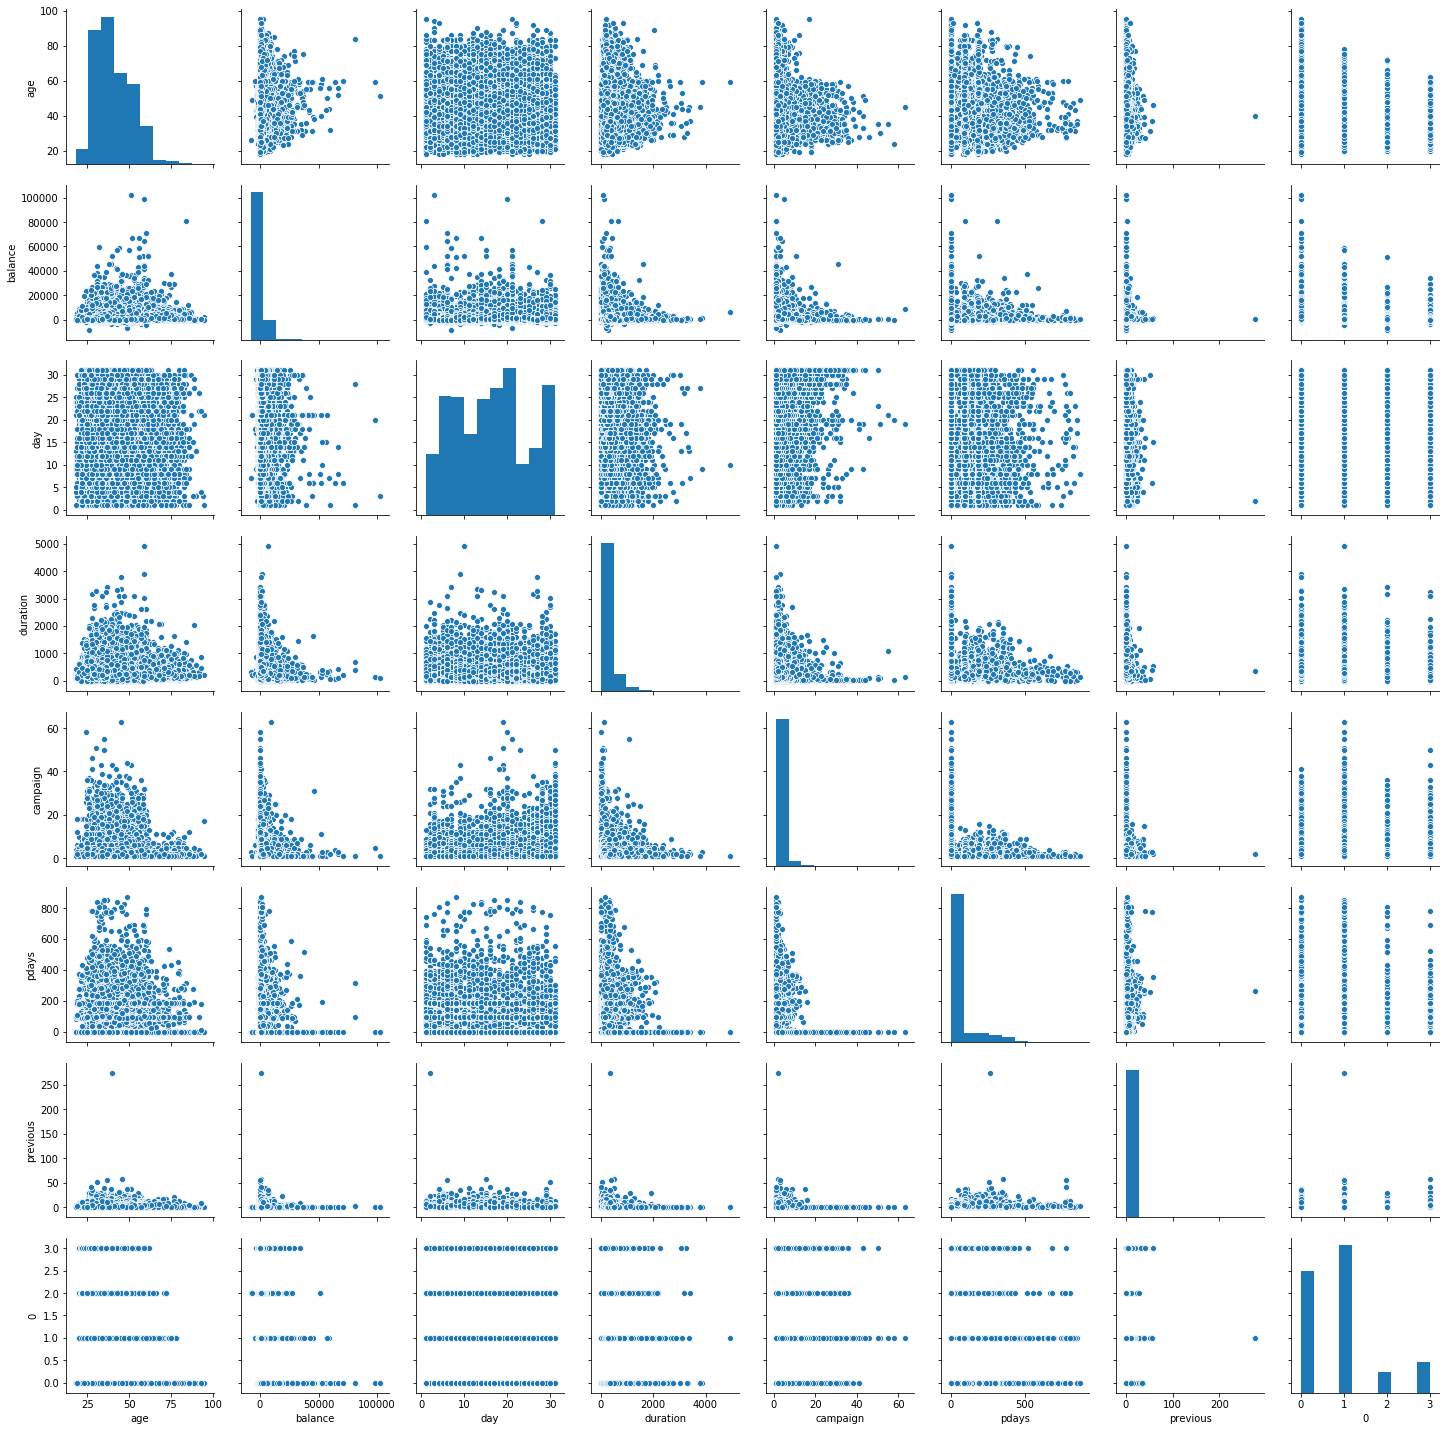

In [11]:
## Verificar correlação entre as variáveis
sb.pairplot(df)

#### Conclusão: Não há correlação.

<Figure size 1440x864 with 0 Axes>

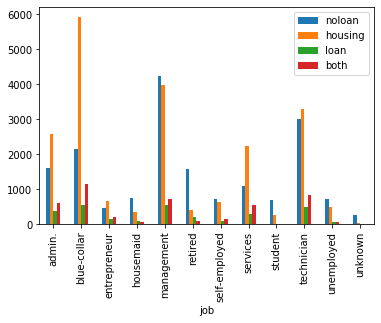

In [12]:
## Histograma de profissões por tipo de empréstimo ##

plt.figure(figsize=(20, 12))
prof = df[0].groupby([df['job'], df[0]]).count()
df_jl = pd.DataFrame(prof.unstack())
df_jl.columns = ['noloan', 'housing', 'loan', 'both']
df_jl.plot.bar()
plt.show()

### Resposta à questão 1:
#### Verificando o gráfico de barras, notamos que a profissão que tem mais tendência a fazer um empréstimo é a "blue-collar" e
#### o tipo de empréstimo é o "housing" ou imobiliário.

#################################################################################################################

### Questão 2:
##### 2. Fazendo uma relação entre número de contatos e sucesso da campanha quais são os pontos relevantes 
##### a serem observados?

Nr. de contatos: 1 Porcentagem: 48 %
Nr. de contatos: 2 Porcentagem: 26 %
Nr. de contatos: 3 Porcentagem: 11 %
Nr. de contatos: 4 Porcentagem: 5 %
Nr. de contatos: 5 Porcentagem: 2 %
Nr. de contatos: 6 Porcentagem: 1 %
Nr. de contatos: 7 Porcentagem: 0 %
Nr. de contatos: 8 Porcentagem: 0 %
Nr. de contatos: 9 Porcentagem: 0 %
Nr. de contatos: 10 Porcentagem: 0 %
Nr. de contatos: 11 Porcentagem: 0 %
Nr. de contatos: 12 Porcentagem: 0 %
Nr. de contatos: 13 Porcentagem: 0 %
Nr. de contatos: 14 Porcentagem: 0 %
Nr. de contatos: 15 Porcentagem: 0 %
Nr. de contatos: 16 Porcentagem: 0 %
Nr. de contatos: 17 Porcentagem: 0 %
Nr. de contatos: 18 Porcentagem: 0 %
Nr. de contatos: 19 Porcentagem: 0 %
Nr. de contatos: 20 Porcentagem: 0 %
Nr. de contatos: 21 Porcentagem: 0 %
Nr. de contatos: 22 Porcentagem: 0 %


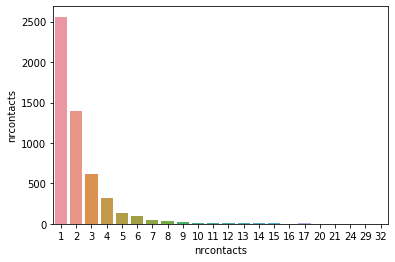

In [13]:
## Criando o dataset e os gráficos de barra para encontrar as relações.
df_camp = []
df_cont = []

for i in range(0, len(df)):
    if (df.iloc[i].y == 'yes'):
        df_camp.append(df.iloc[i].campaign)
        df_cont.append(df.iloc[i].contact)
    
df_camp = pd.DataFrame(df_camp)
df_cont = pd.DataFrame(df_cont)
df_camp = pd.concat([df_camp, df_cont], axis=1)

df_camp.columns=['nrcontacts', 'typecontacts']
cont = df_camp['nrcontacts'].groupby([df_camp['nrcontacts']]).count()


min(df_camp['nrcontacts'])
max(df_camp['nrcontacts'])

cont = pd.DataFrame(cont)

#cont.plot.bar()
sb.barplot(x=cont.index, y=cont.nrcontacts)

for i in range(0, len(cont)):
    nrcont = i + 1
    perc = cont.iloc[i]/len(df_camp) * 100
    perc = int(perc)
    print('Nr. de contatos: ' + str(nrcont) + ' Porcentagem: ' + str(perc) + ' %')
    perc = 0

### Resposta à questão 2:
#### Verificando os gráficos de barras, notamos que o maior sucesso da campanha, está
#### no primeiro e no segundo contato. O terceiro contato ainda tem relevância com 11% aproximadamente, mas
#### a partir do quarto contato, o percentual de sucessos por número de contatos passa a não ter relevância.

#################################################################################################################

### Questão 3:
#### 3. Baseando-se nos resultados de adesão desta campanha qual o número médio e o máximo de ligações 
#### que você indica para otimizar a adesão?
    
#### Para fazer uma análise das ligações, vamos verificar os modos de contato com o cliente que foram utilizados. 
#### Vamos reduzir o dataset e utilizar os dados de um número máximo de seis contatos pois atingem no total, 
#### 93% do total de sucessos na campanha.

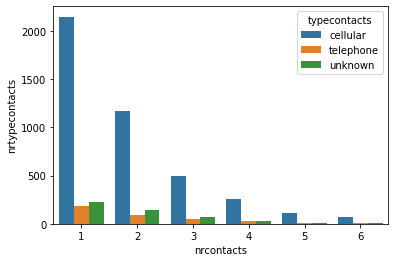

In [14]:
df_camp_sub = []
for j in range(0, len(df_camp)):
    if (df_camp.iloc[j].nrcontacts <= 6):
        df_camp_sub.append(df_camp.iloc[j])

df_camp_sub = pd.DataFrame(df_camp_sub)
camp_sub = df_camp_sub['typecontacts'].groupby([df_camp_sub['nrcontacts'], df_camp_sub['typecontacts']]).count()

camp_sub = pd.DataFrame(camp_sub)
camp_sub.columns = ['nrtypecontacts']
camp_sub.reset_index(inplace=True)


ax = sb.barplot(x = 'nrcontacts', y = 'nrtypecontacts', hue = 'typecontacts', data=camp_sub)

### Resposta à questão 3:
#### Verificando os modos de contato com o cliente, verificamos que o principal modo é através de ligações telefônicas,
#### sejam através de celular ou linha fixa. Com isto, podemos responder à questão 3, eu indico o número médio de
#### 3 ligações pois atingiríamos 85% de sucesso e o número máximo de 6 ligações onde atingiríamos 93% de sucesso.

#################################################################################################################

### Questão 4:
#### 4. O resultado da campanha anterior tem relevância na campanha atual?

In [16]:
## Carregando o dataset de resultados das duas campanhas
df_camprel = df[['poutcome', 'y']]

## Para uma análise de probabilidade condicional, onde iremos avaliar se o resultado da campanha anterior tem
## relação com a campanha atual, iremos utilizar um classificador Naive Bayes


prob_y_success = round(df_camprel['y'][df_camprel['y'] == 'yes'].count() / len(df_camprel), 2)
prob_y_failure = round(df_camprel['y'][df_camprel['y'] == 'no'].count() / len(df_camprel), 2)

prob_pout_success = round(df_camprel['poutcome'][df_camprel['poutcome'] == 'success'].count() / len(df_camprel), 2)
prob_pout_failure = round(df_camprel['poutcome'][df_camprel['poutcome'] == 'failure'].count() / len(df_camprel), 2)
prob_pout_unknown = round(df_camprel['poutcome'][df_camprel['poutcome'] == 'unknown'].count() / len(df_camprel), 2)
prob_pout_other = round(df_camprel['poutcome'][df_camprel['poutcome'] == 'other'].count() / len(df_camprel), 2)




In [17]:
## Criação da tabela com os números de acordo com cada variável da campanha anterior e da atual
df_y_means = df_camprel['y'].groupby([df_camprel['y'], df_camprel['poutcome']]).count()
df_y_means = pd.DataFrame(df_y_means)
df_y_means.columns = ['nr_y']
df_y_means.reset_index(inplace=True)
cols = ['poutcome', 'y', 'nr_y']
df_y_ = df_y_means[cols].copy()

p_out_unknown = df_camprel['poutcome'][df_camprel['poutcome'] == 'unknown'].count()
p_out_other = df_camprel['poutcome'][df_camprel['poutcome'] == 'other'].count()
p_out_failure = df_camprel['poutcome'][df_camprel['poutcome'] == 'failure'].count()
p_out_success = df_camprel['poutcome'][df_camprel['poutcome'] == 'success'].count()

In [18]:
## Probabilidades:
## P(campanha atual sucesso | campanha anterior sucesso):
#prob_cats_cans = round(df_y_.iloc[6].nr_y / df_y_.nr_y.sum(), 2)
prob_cats_cans = round(prob_pout_success * prob_y_success, 4)
print('P(campanha atual sucesso | campanha anterior sucesso): ' + str(prob_cats_cans))

## P(campanha atual sucesso | campanha anterior falha):
prob_cats_canf = round(prob_pout_failure * prob_y_success, 4)
print('P(campanha atual sucesso | campanha anterior falha)  : ' + str(prob_cats_canf))

## P(campanha atual sucesso | campanha anterior other):
prob_cats_cano = round(prob_pout_other * prob_y_success, 4)
print('P(campanha atual sucesso | campanha anterior other)  : ' + str(prob_cats_cano))

## P(campanha atual sucesso | campanha anterior unknown):
prob_cats_canu = round(prob_pout_unknown * prob_y_success, 4)
print('P(campanha atual sucesso | campanha anterior unknown): ' + str(prob_cats_canu))


## P(campanha atual falha | campanha anterior sucesso):
prob_catf_cans = round(prob_pout_success * prob_y_failure, 4)
print('P(campanha atual falha   | campanha anterior sucesso): ' + str(prob_catf_cans))

## P(campanha atual falha | campanha anterior falha):
prob_catf_canf = round(prob_pout_failure * prob_y_failure, 4)
print('P(campanha atual falha   | campanha anterior falha)  : ' + str(prob_catf_canf))

## P(campanha atual falha | campanha anterior other):
prob_catf_cano = round(prob_pout_other * prob_y_failure, 4)
print('P(campanha atual falha   | campanha anterior other)  : ' + str(prob_catf_cano))

## P(campanha atual falha | campanha anterior unknown):
prob_catf_canu = round(prob_pout_unknown * prob_y_failure, 4)
print('P(campanha atual falha   | campanha anterior unknown): ' + str(prob_catf_canu))

P(campanha atual sucesso | campanha anterior sucesso): 0.0036
P(campanha atual sucesso | campanha anterior falha)  : 0.0132
P(campanha atual sucesso | campanha anterior other)  : 0.0048
P(campanha atual sucesso | campanha anterior unknown): 0.0984
P(campanha atual falha   | campanha anterior sucesso): 0.0264
P(campanha atual falha   | campanha anterior falha)  : 0.0968
P(campanha atual falha   | campanha anterior other)  : 0.0352
P(campanha atual falha   | campanha anterior unknown): 0.7216


#### Resposta à questão 4:
#### interpretação dos resultados:
#### Ao verificarmos que um resultado desconhecido da campanha anterior é maior do que qualquer valor
#### de sucesso ou falha de resultados de campanha nas campanhas atuais, percebemos que as campanhas 
#### anteriores não tem relevância nos resultados da campanha atual. O fato de se ter tido sucesso ou
#### fracasso na campanha anterior, não resultou em nenhuma variação no resultado de sucesso ou fracasso da
#### campanha atual.

#################################################################################################################

### Questão 5:
#### 5. Qual o fator determinante para que o banco exija um seguro de crédito?

#### Os bancos utilizam vários fatores para compôr a análise de risco de um cliente, alguns são:
#### - Comportamento do cliente em relação ao pagamento de créditos anteriores.
#### - Comprometimento de renda que o cliente tem com outros empréstimos já contraídos.
#### - Saldo médio.
#### - Se o cliente mantém os pagamentos mesmo em caso de instabilidade externa como aumento dos juros, redução da
#### renda, etc.
#### - Relacionamento do cliente con o banco, se o cliente já tem outros produtos e também outros empréstimos.

#### De acordo com os itens acima e verificando quais dados temos no dataset, considero os seguintes fatores 
#### importantes para que o banco exija ou não o seguro de crédito:
#### - Idade não avançada.
#### - Saldo médio bom.
#### - Se possui empréstimo imobiliário e pessoal, significa que o cliente é bom pagador.
#### - Se possui empréstimo imobiliário, é um indicador de que tem um patrimônio.
#### - Se possui o "term deposit", indica bom relacionamento com o banco.

#### Excluí as seguintes variáveis e listo os motivos:
#### - job: independente do tipo de trabalho ou até mesmo se está desempregado ou é estudante, acredito que este 
#### fator é irrelevante para indicar risco ou não ao crédito.
#### - marital: Acredito que o estado civil do cliente também é pouco significativo pois ao mesmo tempo que pode 
#### ajudar no sentido de ter ou não um apoio financeiro, também pode gerar mais gastos e comprometer a renda.
#### - education: Não vejo como importante este atributo também pois pessoas sem educação formal podem administrar
#### bem seu dinheiro ou não, da mesma forma, pessoas com nível superior também podem ou não serem bons administ-
#### radores.

In [19]:
## Iniciando as análises separando o dataset com as variáveis que julgo mais importantes:

df_seg = df[['age', 'balance', 'y', 0]]
df_seg.y.replace(('yes', 'no'), (1, 0), inplace = True)

df_seg = pd.DataFrame(df_seg)

df_seg.columns = ['age', 'balance', 'term_deposit', 'loan']

des_seg = df_seg.describe()

col_age = 'age'
col_balance = 'balance'

/home/antonio/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [20]:
## Identificando estatisticamente possíveis outliers em age

print('Calculo de outliers de ' + col_age)
print('1º Quartil: ', df_seg[col_age].quantile(q = 0.25))
print('2º Quartil: ', df_seg[col_age].quantile(q = 0.50))
print('3º Quartil: ', df_seg[col_age].quantile(q = 0.75))
print('4º Quartil: ', df_seg[col_age].quantile(q = 1.00))
print(col_age + ' acima de: ', df_seg[col_age].quantile(q = 0.75) + 
                  1.5*(df_seg[col_age].quantile(q = 0.75) - df_seg[col_age].quantile(q = 0.25)), 'são outliers')
print()
print(col_age + ' abaixo de: ',df_seg[col_age].quantile(q = 0.75) - 1.5*(df_seg[col_age].quantile(q = 0.75) - df_seg[col_age].quantile(q = 0.25)), 'são outliers')
print()
print('Numero de outliers: ', df_seg[df_seg[col_age] > 70.5][col_age].count())
print('Numero de clientes: ', len(df))
print('Outliers são:', round(df_seg[df_seg[col_age] > 70.5][col_age].count()*100/len(df_seg),2), '%')
print()
print()


## Analisando o coeficiente de variação de age

print('Variação de: ' + col_age)
print('Média:', round(df_seg[col_age].mean(), 1))
print('Desvio padrão :', round(df_seg[col_age].std(), 1))
print('Coeficiente de Variação  :', round(df_seg[col_age].std()*100/df_seg[col_age].mean(), 1), end='%.')
if round(df_seg[col_age].std()*100/df_seg[col_age].mean(), 1) < 15:
    print(' Baixa variação')
elif ((round(df_seg[col_age].std()*100/df_seg[col_age].mean(), 1) >= 15) and (round(df_seg[col_age].std()*100/df_seg[col_age].mean(), 1)) <= 30):
    print(' Média variação')
else:
    print(' Alta variação')
print()

Calculo de outliers de age
1º Quartil:  33.0
2º Quartil:  39.0
3º Quartil:  48.0
4º Quartil:  95.0
age acima de:  70.5 são outliers

age abaixo de:  25.5 são outliers

Numero de outliers:  487
Numero de clientes:  45211
Outliers são: 1.08 %


Variação de: age
Média: 40.9
Desvio padrão : 10.6
Coeficiente de Variação  : 25.9%. Média variação



In [21]:
## Identificando estatisticamente possíveis faixas de exclusão baseadas em quartis e outliers

print('Calculo de outliers de ' + col_balance)
print('1º Quartil: ', df_seg[col_balance].quantile(q = 0.25))
print('2º Quartil: ', df_seg[col_balance].quantile(q = 0.50))
print('3º Quartil: ', df_seg[col_balance].quantile(q = 0.75))
print('4º Quartil: ', df_seg[col_balance].quantile(q = 1.00))
print(col_balance + ' abaixo de: ', 1.5*(df_seg[col_balance].quantile(q = 0.75) - df_seg[col_balance].quantile(q = 0.25)) - df_seg[col_balance].quantile(q = 0.75), 'são outliers')
print()
print('Numero de outliers: ', df_seg[df_seg[col_balance] < 606.0][col_balance].count())
print('Numero de clientes: ', len(df))
print('Outliers são:', round(df_seg[df_seg[col_balance] < 606.0][col_balance].count()*100/len(df_seg),2), '%')
print()
print()


## Analisando o coeficiente de variação de balance

print('Variação de: ' + col_balance)
print('Média:', round(df_seg[col_balance].mean(), 1))
print('Desvio padrão :', round(df_seg[col_balance].std(), 1))
print('Coeficiente de Variação  :', round(df_seg[col_balance].std()*100/df_seg[col_balance].mean(), 1), end='%.')
if round(df_seg[col_balance].std()*100/df_seg[col_balance].mean(), 1) < 15:
    print(' Baixa variação')
elif ((round(df_seg[col_balance].std()*100/df_seg[col_balance].mean(), 1) >= 15) and (round(df_seg[col_balance].std()*100/df_seg[col_balance].mean(), 1)) <= 30):
    print(' Média variação')
else:
    print(' Alta variação')
print()

Calculo de outliers de balance
1º Quartil:  72.0
2º Quartil:  448.0
3º Quartil:  1428.0
4º Quartil:  102127.0
balance abaixo de:  606.0 são outliers

Numero de outliers:  25610
Numero de clientes:  45211
Outliers são: 56.65 %


Variação de: balance
Média: 1362.3
Desvio padrão : 3044.8
Coeficiente de Variação  : 223.5%. Alta variação



#### Identificamos que os clientes que necessitam de seguro de crédito são:
#### - Menores que 25 e maiores que 70 anos. 
#### - Saldo médio menor que 606 euros.
#### - Não possuírem empréstimos imobiliários.
#### - Não possuírem investimentos ("term deposit").

In [22]:
## Identificando estes clientes na base, temos:

df_segcred = []
for k in range(0, len(df_camp)):
    if (df.iloc[k].age < 25) or (df.iloc[k].age > 70):
        if (df.iloc[k].balance < 606.0):
            if (df.iloc[k].housing == 'no'):
                if (df.iloc[k].y == 'no'):
                    df_segcred.append(df.iloc[k])

df_segcred = pd.DataFrame(df_segcred)

## O número de clientes que necessitam de seguro de crédito, são 7. São eles:
print(df_segcred) 

      age          job  marital  education default  balance housing loan  \
1836   21      student   single  secondary      no        6      no   no   
1933   24      student   single  secondary      no      304      no   no   
2208   23       admin.   single  secondary      no        5      no   no   
2670   23  blue-collar  married    primary      no     -213      no   no   
2702   24  blue-collar  married  secondary      no       32      no   no   
3847   24     services   single  secondary      no        0      no   no   
3953   24      retired   single  secondary      no      366      no  yes   

      contact  day month  duration  campaign  pdays  previous poutcome   y  0  
1836  unknown    9   may       622         1     -1         0  unknown  no  0  
1933  unknown    9   may       180         3     -1         0  unknown  no  0  
2208  unknown   12   may       413         1     -1         0  unknown  no  0  
2670  unknown   13   may       165         2     -1         0  unknown 

#################################################################################################################

### Questão 6:
#### 6. Quais são as características mais proeminentes de um cliente que possua empréstimo imobiliário?

In [23]:
## Inicialmente irei criar um dataset com as características do cliente e se possui ou não o empréstimo imobiliário.

df_cli = df[['age', 'job', 'marital', 'education', 'default', 'balance', 'housing']]

data_new = pd.get_dummies(df_cli, columns=['job','marital', 'education','default'])

data_new.housing.replace(('yes', 'no'), (1, 0), inplace=True)

df_age = pd.DataFrame(pd.crosstab(index=df_cli['age'], columns=df_cli['housing']))
age = pd.DataFrame(df_age.std(axis=1)).mean(axis=0)
df_job = pd.DataFrame(pd.crosstab(index=df_cli['job'], columns=df_cli['housing']))
df_marital = pd.DataFrame(pd.crosstab(index=df_cli['marital'], columns=df_cli['housing']))
df_education = pd.DataFrame(pd.crosstab(index=df_cli['education'], columns=df_cli['housing']))
df_default = pd.DataFrame(pd.crosstab(index=df_cli['default'], columns=df_cli['housing']))
df_balance = pd.DataFrame(pd.crosstab(index=df_cli['balance'], columns=df_cli['housing']))


data_y = pd.DataFrame(data_new['housing'])
data_X = data_new.drop(['housing'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.3, random_state=2, stratify=data_y)



xgbc = XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgbc.fit(X_train,y_train.squeeze().values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.08, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.75, verbosity=1)

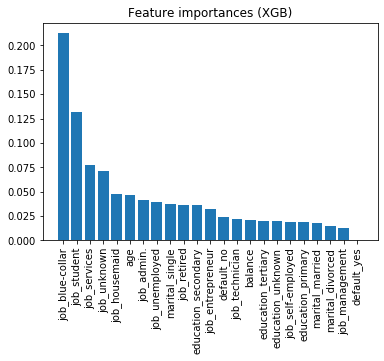

In [24]:
## Para analisar as características mais importantes que determinam quem possui ou não um empréstimo imobiliário, 
## utilizarei o analisador de importância de variáveis do XGBoost.

headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgbc.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

## plot importância das variáveis
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

In [25]:
## Testando a acurácia do modelo

y_train_preds = xgbc.predict(X_train)
y_test_preds = xgbc.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

predictions = lr.predict(X_test)
## Matriz de confusão
print(confusion_matrix(y_test, predictions))


print('\n')

## Relatório da classificação
print(classification_report(y_test,predictions))

XGB accuracy score for train: 0.695: test: 0.652
0.6273960483633146
[[2706 3319]
 [1735 5804]]




/home/antonio/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/antonio/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.61      0.45      0.52      6025
           1       0.64      0.77      0.70      7539

    accuracy                           0.63     13564
   macro avg       0.62      0.61      0.61     13564
weighted avg       0.62      0.63      0.62     13564



### Resposta à questão 6:
#### Conforme as análises feitas por classificadores, as 5 características mais proeminentes do cliente,
#### em ordem de importância da maior para a menor, são:
#### 1 - Profissão.
#### 2 - Idade.
#### 3 - Estado civil.
#### 4 - Educação.
#### 5 - Não ter empréstimos.